# Notebook con Informacion Relevante al Certamen 1 de Inferencia Estadistica


In [ ]:
#Librerias estandar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Mejor lectura de csv
import polars as pl

#Para pruebas T y Distribuciones
from scipy import stats

#para el analisis de Matching
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## FUNCIONES UTILES

Funciones q pudeo copiar y pegar para hacer gran parte del trabajo

Cortador de outliers

In [ ]:
def cortar_outliers(df, columna): #Cortamos los outliers segun el IQR
    """Se devuelve un Dataframe con los Outliers de la columna especificada siendo removidos
    -----------
    df: Dataframe entero
    columna: columna sobre la cual se quiere remover los outliers (ej: analisis sobre los SEXOs, trabajamos sobre esa)
    """
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    print(f"Límite inferior: {limite_inferior:.2f}")
    print(f"Límite superior: {limite_superior:.2f}")

    # Identificación de outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    print(f"Número de outliers: {len(outliers)}")

    # DataFrame sin outliers
    df_sin_outliers = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]
    return df_sin_outliers

Tamaño necesario mejora en STD

In [ ]:
from statsmodels.stats.power import TTestIndPower

def neccesary_size(SD, alpha=0.05, power=0.8, groups=2):
    """ Calcula el tamaño muestral necesario para detectar una mejora desviaciones estándar. En 2 grupos
    -----------
    SD: tamaño del efecto Desviacion estandar (mejora buscada)
    alpha: nivel de significancia (default es 0.05)
    power: potencia deseada (default es 80%, osea 0.8)
    """

    # Calcular tamaño muestral por grupo
    analysis = TTestIndPower()
    sample_size_per_group = analysis.solve_power(effect_size=SD, alpha=alpha, power=power, alternative='two-sided')
    total_sample_size = sample_size_per_group * groups #por 2 ya que esta partido a la mitad (2 grupos)

    print(f"Tamaño muestral necesario por grupo: {round(sample_size_per_group)}")
    print(f"Tamaño muestral total: {round(total_sample_size)}")

#SD = 0.5  # tamaño del efecto (0.5 SD)
neccesary_size(0.5)

Tamaño muestral necesario por grupo: 1571
Tamaño muestral total: 3141


### Estadisticas

USO BUENO: Estadisticas de una Serie

In [ ]:
def medidas_tendencia(serie): 
    """imprime Las Medidas de Tendencia Central y Dispersion, deteccion de atipicos y el Intervalo de Confianza
    -----------
    - serie: Serie que se quiere analizar
    -----------
    *Para usar sobre un Dataframe, usar esta funcion dentro de un loop.
    """
    print("ESTADISTICOS DE", serie.name)

    print("\nMEDIDAS DE TENDENCIA CENTRAL")
    print("Media:", serie.mean())
    print("Mediana:",serie.median())
    print("Moda:",serie.mode()[0])

    print("\nMEDIDAS DE DISPERSION")
    print("Desviacion Estandar:",serie.std())
    print("Rango:", serie.max()-serie.min())
    print("Percentiles 25%:", serie.quantile(0.25))
    print("Percentiles 50%:", serie.quantile(0.5))
    print("Percentiles 75%:", serie.quantile(0.75))
    IQR = serie.quantile(0.75) - serie.quantile(0.25)

    # Definir límites para Atipicos
    limite_inferior = serie.quantile(0.25) - 1.5 * IQR
    limite_superior = serie.quantile(0.75) + 1.5 * IQR
    print(f"\nLimites Atipicos: [{limite_inferior}, {limite_superior}]")


    #INTERVALO DE CONFIANZA
    conf = 0.95 #la confianza a usar
    n = len(serie) #tamaño de la muestra
    media=serie.mean()
    #intervalo de confianza
    e= stats.t.interval(confidence=conf, df=n-1, loc=media, scale=stats.sem(serie)) #sem = error medio
    print("\nIntervalos de Confianza:",e)

Calculo de Multiples distribucione sestadisticas + p-valor de Ajuste a estas

In [ ]:
def distribuciones_tests(serie):
    """Funcion que grafica multiples Distribuciones Estadisticas, estas siendo:
    -Normal
    -Gamma
    -LogNormal
    -Exponencial
    -Chi Cuadrado
    -Weibull

    Ademas, calcula los Ajustes de P-value y Ks stats por cada distribucion (diciendo si se ajusta o no)
    -----------
    Serie = La serie que se quiere analizar
    """
    # Probamos ajustar varias distribuciones
    distribuciones = ['norm','gamma', 'lognorm', 'expon','chi2','weibull_min']
    #faltan Poisson y Binom

    #resultados_ajuste = {}

    plt.figure(figsize=(15, 10))

    # Histogram de los datos reales
    plt.subplot(4, 2, 1)
    sns.histplot(serie, kde=True, stat='density', color='skyblue')
    plt.title('Distribución de Días de Estancia')
    plt.xlabel('Días')

    # Ajustamos cada distribución y la visualizamos
    for i, dist_name in enumerate(distribuciones, 2):
        # Obtenemos la distribución desde scipy.stats
        distribution = getattr(stats, dist_name)
        
        # Ajustamos los parámetros
        params = distribution.fit(serie)
        
        # Realizamos test K-S
        ks_stat, p_value = stats.kstest(serie, dist_name, params)

        print(f"\nResultados de ajuste para la Distribución {dist_name.capitalize()}:")
        print(f"  p-valor: {p_value:.4f} {'(Buen ajuste)' if p_value > 0.05 else '(Rechaza ajuste)'}")
        print(f"  Estadístico K-S: {ks_stat:.4f}")
        print(f"  Parámetros: {', '.join([f'{p:.4f}' for p in params])}")
        
        # Generamos puntos para graficar la distribución ajustada
        x = np.linspace(0, np.percentile(serie, 95), 100)
        pdf = distribution.pdf(x, *params)
        
        # Graficamos
        plt.subplot(4, 2, i)
        sns.histplot(serie, kde=True, stat='density', color='skyblue', label='Datos reales')
        plt.plot(x, pdf, 'r-', label=f'Distribución {dist_name} ajustada')
        plt.title(f'Ajuste con {dist_name}\np-valor K-S: {p_value:.4f}')
        plt.xlabel('Días')
        plt.legend()


    plt.tight_layout()
    plt.show()

### Test T

In [ ]:
def test_t_2_medias(df_1,df_2): 
    """ Prueba T de 2 medias distintas
    -----------
    - df_1 = Serie
    - df_2 = Serie
    """
    levene_stat, levene_pval = stats.levene(df_1, df_2)
    equal_var = levene_pval >= 0.05  # True si podemos asumir varianzas iguales

    # Prueba t para dos muestras independientes
    t_stat, p_valor = stats.ttest_ind(df_1, df_2, equal_var=equal_var)

    # Mostrar resultados
    print(f"Prueba t para dos muestras independientes") # - Dias de Estancia por Servicio de Salud")
    
    #print(f"Hipótesis nula (H₀): la Estancia media es igual a traves de los Servicios de Salud")
    #print(f"Hipótesis alternativa (H₁): la Estancia media es diferente a traves de los Servicios de Salud\n")


    print(f"Media grupo 1: {df_1.mean():.4f}")
    print(f"Media grupo 2: {df_2.mean():.4f}")

    print(f"Diferencia de medias: {df_1.mean() - df_2.mean():.4f}")
    print(f"\nPrueba de Levene para igualdad de varianzas: p={levene_pval:.4f} ({'varianzas iguales' if equal_var else 'varianzas diferentes'})")
    print(f"Estadística t: {t_stat:.4f}")
    print(f"Valor p: {p_valor:.4f}\n")

    # Decisión estadística
    alpha = 0.05
    if p_valor < alpha:
        print(f"Decisión: Rechazamos la hipótesis nula (p < {alpha})")
        #print(f"Conclusión: Existe una diferencia significativa en la Estancia Media entre el Servicio de Salud Chiloé y Metropolitana Suroriente")
    else:
        print(f"Decisión: No rechazamos la hipótesis nula (p ≥ {alpha})")
        #print(f"Conclusión: No hay evidencia suficiente para afirmar que existe diferencia en la Estancia Media entre los Servicios de Salud")


Retorna ambos pruebas T, diciendo cual seria recomendable usar en este caso.

In [ ]:
def perform_ttests(group1, group2): #pruebas de pruebas T tests
    """Realiza t-test con varianzas iguales y desiguales, y retorna resultados.
    Ademas, dice cual de las 2 pruebas es mal util para la ocasion.
    -----------
    - group1 = Serie
    - group2 = Serie
    -----------
    Retorna un diccionario conteniendo los resultados de las 3 pruebas
    """
    alpha =0.05 #alpha estandar

    # T-test con varianzas iguales (pool=True es el valor por defecto)
    t_equal, p_equal = stats.ttest_ind(group1, group2, equal_var=True)

    # T-test con varianzas desiguales (Welch's t-test)
    t_welch, p_welch = stats.ttest_ind(group1, group2, equal_var=False)

    # Test de Levene para verificar igualdad de varianzas
    levene_stat, levene_p = stats.levene(group1, group2)

    test_results= {
        "equal_var": {"t": t_equal, "p": p_equal},
        "welch": {"t": t_welch, "p": p_welch},
        "levene": {"stat": levene_stat, "p": levene_p}
    }

    # Identificar decisión basada en test de Levene
    levene_decision = "Rechazar H0: Las varianzas son diferentes" if test_results["levene"]["p"] < alpha else "No rechazar H0: No hay evidencia de varianzas diferentes"

    # Tabla de resultados
    results_text = [
        f"Test de Levene para igualdad de varianzas:",
        f"  Estadístico = {test_results['levene']['stat']:.4f}, p-valor = {test_results['levene']['p']:.4f}",
        f"  Decisión ({alpha:.2f}): {levene_decision}",
        "",
        f"T-test asumiendo varianzas iguales (Student):",
        f"  t = {test_results['equal_var']['t']:.4f}, p-valor = {test_results['equal_var']['p']:.4f}",
        f"  Decisión ({alpha:.2f}): {'Rechazar H0' if test_results['equal_var']['p'] < alpha else 'No rechazar H0'}",
        "",
        f"T-test asumiendo varianzas desiguales (Welch):",
        f"  t = {test_results['welch']['t']:.4f}, p-valor = {test_results['welch']['p']:.4f}",
        f"  Decisión ({alpha:.2f}): {'Rechazar H0' if test_results['welch']['p'] < alpha else 'No rechazar H0'}"
    ]

    # Añadir texto sobre qué test usar
    advice_text = ""
    if test_results["levene"]["p"] < alpha:
        advice_text = "Recomendación: Las varianzas son significativamente diferentes. Utilice el t-test de Welch."
    else:
        advice_text = "Recomendación: No hay evidencia de varianzas diferentes. Ambos tests son adecuados, pero el t-test estándar tiene mayor potencia."
    
    print(f"Media grupo 1: {group1.mean():.4f}")
    print(f"Media grupo 2: {group2.mean():.4f}")

    print(f"Diferencia de medias: {group1.mean() - group2.mean():.4f}\n")
    print(advice_text)
    for i in results_text:
        print(i)
    

    return test_results

### Matching y A/B

Añadir columna "propensity_score"

In [ ]:
def col_propensity_score(df, lista_confusoras, lista_char):
    """
    Devuelve el Dataframe entregado,con el propensity score
    -----------
    - df: Dataframe 
    - lista_confusoras: lista con variables confusoras
    - lista_char: lista con variables confusoras categoricas
    -----------
    Retorna:
    --------
    DataFrame con columna "propensity_score"
    -----------
    !!WARNING!!
    necesita la creacion de la columna "tratamiento", previo al ingreso
    """
    #confusoras
    X = df[lista_confusoras]
    # Convertir variables categóricas a variables dummy (one-hot encoding)
    X = pd.get_dummies(X, columns=lista_char, drop_first=True)
    y = df['tratamiento']

    # Eliminar filas con valores faltantes en X o y
    mask = X.notnull().all(axis=1) & y.notnull() #mascara q elimina los NULL
    X = X[mask]
    y = y[mask]

    # 3. Estandarizar variables numéricas para mejorar el ajuste del modelo
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. Ajustar modelo de regresión logística para calcular propensity scores
    # El modelo predice la probabilidad de pertenecer al grupo "tratamiento" según las covariables
    modelo_ps = LogisticRegression(random_state=42)
    modelo_ps.fit(X_scaled, y)
    # Guardamos el propensity score en el DataFrame original
    df.loc[X.index, 'propensity_score'] = modelo_ps.predict_proba(X_scaled)[:, 1]

    display(X_scaled.shape)
    #regresa el Dataframe actualizado con la nueva columna
    return df


#se crea la columna tratamiento
#datos_servicios['tratamiento'] = (datos_servicios['SERVICIO_SALUD'] == 'METROPOLITANO NORTE').astype(int)

#se listan las variables confusoras y las que son categoricas.
#variables_confusoras=['EDAD', 'TIPO_INGRESO', 'IR_29301_PESO']
#variables_categoricas=['TIPO_INGRESO']
#col_propensity_score(datos_servicios,variables_confusoras,variables_categoricas)

Match

In [ ]:
# 5. Función para realizar matching
def match_propensity_scores(df, treatment_col='tratamiento', score_col='propensity_score', caliper=0.05):
    #funcion del profe para realizar Matching
    """
    Realiza matching por propensity score con un caliper dado.

    Parámetros:
    -----------
    df : DataFrame
        DataFrame con los datos
    treatment_col : str
        Nombre de la columna que indica el tratamiento (1) o control (0)
    score_col : str
        Nombre de la columna con propensity scores
    caliper : float
        Distancia máxima permitida para el matching

    Retorna:
    --------
    DataFrame con los pares matcheados
    -----------
    !!WARNING!!
    NO USAR SOBRE MUESTRAS DE 10MIL, PUES SE DEMORA DEMASIADO
    """
    # Separar tratamiento y control
    treated = df[df[treatment_col] == 1].copy() 
    control = df[df[treatment_col] == 0].copy() 

    # Almacenar índices de matches (usar índices originales)
    treated_indices = []
    control_indices = []

    # Para cada caso tratado, encontrar el control más cercano
    available_controls = control.copy()
    for treated_idx, treated_row in treated.iterrows():
        ps_treated = treated_row[score_col]
        available_controls['distance'] = abs(available_controls[score_col] - ps_treated)

        # Si hay controles disponibles
        if not available_controls.empty:
            best_match_idx = available_controls['distance'].idxmin()
            best_match_distance = available_controls.loc[best_match_idx, 'distance']

            # Verificar caliper
            if best_match_distance < caliper:
                treated_indices.append(treated_idx)
                control_indices.append(best_match_idx)

                # Eliminar el control usado para no reutilizarlo (para no tener un sesgo nuevo)
                available_controls = available_controls.drop(best_match_idx)

    # Crear DataFrame con los pares matcheados usando los índices originales
    matched_treated = treated.loc[treated_indices].reset_index(drop=True)
    matched_control = control.loc[control_indices].reset_index(drop=True)

    return matched_treated, matched_control

# 6. Realizar el matching
#treated_matched, control_matched = match_propensity_scores(datos_servicios)
#print(f"Número de pares matcheados: {len(treated_matched)}")

Grafica Propensity_Score antes y despues de Matcheo

In [ ]:
#Visualizar distribución de propensity scores antes y después del matching
def vizual_propensity_before_after(df, group_name, name_1, name_0, lista_num, lista_char,t_matched=treated_matched,c_matched=control_matched):
    """
    Comparacion Vizual del puntaje de propensidad antes y despues del matching
    -----------
    - df: Dataframe ya tratado
    - group_name: nombre del grupo (columna) analisis.
    - name_1: Str nombre columna tratamiento (la que tomamos como 1)
    - name_0: Str nombre de columna que tomamos como 0
    - lista_num: lista de variables numericas a revisar
    - lista_char: lista de variables categoricas a revisar
    -----------
    !!WARNING!!
    Se usa despues de match_propensity_scores(), pues depende de que sus returns esten inicializados
    """
    plt.figure(figsize=(12, 5))

    # Antes del matching
    plt.subplot(1, 2, 1)
    sns.histplot(df[df['tratamiento']==1]['propensity_score'],
                color='blue', alpha=0.5, label=name_1, kde=True)
    sns.histplot(df[df['tratamiento']==0]['propensity_score'],
                color='green', alpha=0.5, label=name_0, kde=True)
    plt.title('Propensity Scores - Antes del Matching')
    plt.xlabel('Propensity Score')
    plt.legend()

    # Después del matching
    plt.subplot(1, 2, 2)
    sns.histplot(t_matched['propensity_score'], color='blue', alpha=0.5,
                label=name_1, kde=True)
    sns.histplot(c_matched['propensity_score'], color='green', alpha=0.5,
                label=name_0, kde=True)
    plt.title('Propensity Scores - Después del Matching')
    plt.xlabel('Propensity Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Balance numérico antes del matching
    balance_before_num = df.groupby(group_name)[lista_num].mean()

    # Balance numérico después del matching
    dicc ={}
    for i in lista_num:
        dicc[i] = [t_matched[i].mean(), c_matched[i].mean()]

    balance_after_num = pd.DataFrame(dicc, index=[name_1, name_0])

    print("\nBalance de covariables numéricas antes del matching:")
    print(balance_before_num)
    print("\nBalance de covariables numéricas después del matching:")
    print(balance_after_num)


    #Comparacion de Categoricas
    for i in range(len(lista_char)): 
        # Balance categórico antes del matching
        balance_before_cat = pd.crosstab(df[group_name], df[lista_char[i]], normalize='index')
        # Balance categórico después del matching

        balance_after_cat = pd.DataFrame({
            name_1: t_matched[lista_char[i]].value_counts(normalize=True),
            name_0: c_matched[lista_char[i]].value_counts(normalize=True)
        }).fillna(0).T
        
        print("==============================")
        print("\nDistribución de TIPO_INGRESO antes del matching:")
        print(balance_before_cat)
        print("\nDistribución de TIPO_INGRESO después del matching:")
        print(balance_after_cat)

#ejemplo implementacion
#variables_numericas = ['EDAD','severidad']
#variables_categoricas = ['TIPO_INGRESO']
#vizual_propensity_before_after(datos_actividad,"SEXO","HOMBRE","MUJER",variables_numericas, variables_categoricas)

Comparacion AB (MATCH y No MATCH)

In [ ]:
    # Ahora podemos realizar la prueba t con muestras balanceadas
    # Se compara la estancia hospitalaria (DIAS_ESTANCIA) entre los dos servicios de salud
    # usando solo los pacientes matcheados por propensity score (grupos comparables).
def test_t_AB_comparasion(df,columna_main, columna_analisis,name_1,name_0, title_var_analisis):
    """
    Comparacion de resultados en AB del test T (Student).
    Se compara entre pre y post MATCHing
    -----------
    - df: Dataframe ya tratado
    - columna_main: columna principal del analisis, desde donde se dividen los grupos (ej: SERVICIO_SALUD)
    - columna_analisis: columna que se busca analizaar desde los rupos formados de la columna_main (ej: DIAS_ESTANCIA)
    - name_1: nombre columna tratamiento (la que tomamos como 1)
    - name_0: nombre de columna que tomamos como 0
    - title_var_analisis: el ylabel(). Es el titulo que se le da a las variables de la columna_analisis
    -----------
    !!WARNING!!
    -Se requiere sacar el p_value original del conjunto Pre-MATCH
    -Se usa despues de match_propensity_scores(), pues depende de que sus returns esten inicializados
    """
#dias estancia  = columna_analisis
#SERVICIO_SALUD = columna_main
    t_stat_matched, p_value_matched = stats.ttest_ind(
        treated_matched[columna_analisis],
        control_matched[columna_analisis],
        equal_var=False
    )

    # Insights y resumen de la comparación
    print("=== INSIGHTS DE LA COMPARACIÓN ===")
    print(f"Antes del matching: p-valor = {p_value:.3e}")
    print(f"Después del matching: p-valor = {p_value_matched:.3e}")
    print(f"Media estancia (grupo 1, matched): {treated_matched[columna_analisis].mean():.2f} días")
    print(f"Media estancia (grupo 0, matched): {control_matched[columna_analisis].mean():.2f} días")
    diff_matched = treated_matched[columna_analisis].mean() - control_matched[columna_analisis].mean()
    print(f"Diferencia de medias tras matching: {diff_matched:.2f} días")

    if p_value_matched < 0.05:
        #...en la estancia hospitalaria entre los servicios
        print("→ Hay una diferencia estadísticamente significativa tras el ajuste por propensity score.")
    else:
        print("→ No hay evidencia suficiente de diferencia significativa tras el ajuste por propensity score.")

    print("\nNota: El matching permite comparar grupos con características similares, reduciendo el sesgo de selección.")

    diff =  df[df[columna_main] == name_1][columna_analisis].mean() - df[df[columna_main] == name_0][columna_analisis].mean()
    se = np.sqrt(df[df[columna_main] == name_1][columna_analisis].var()/len(df[df[columna_main] == name_1][columna_analisis]) +
                df[df[columna_main] == name_0][columna_analisis].var()/len(df[df[columna_main] == name_0][columna_analisis]))
    ci_lower = diff - 1.96 * se
    ci_upper = diff + 1.96 * se

    print("\n=== COMPARACIÓN RESULTADOS DEL A/B TEST ===")
    print(f"\n--- RESULTADOS DEL A/B TEST (Not MATCHED)---")
    print(f"Diferencia en {title_var_analisis} ({name_1} - {name_0}): {diff:.2f} días")
    print(f"Intervalo de confianza 95%: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"Valor p: {p_value:.4f}")

    if p_value < 0.05:
        print(f"Conclusión: Hay una diferencia estadísticamente significativa en las medias de {title_var_analisis}")
    else:
        print(f"Conclusión: No hay evidencia suficiente para afirmar una diferencia en {title_var_analisis}")

    diff = treated_matched[columna_analisis].mean() - control_matched[columna_analisis].mean()
    se = np.sqrt(treated_matched[columna_analisis].var()/len(treated_matched) +
                control_matched[columna_analisis].var()/len(control_matched))
    ci_lower = diff - 1.96 * se
    ci_upper = diff + 1.96 * se

    print(f"\n--- RESULTADOS DEL A/B TEST (MATCHED)---")
    print(f"Diferencia en {title_var_analisis} ({name_1} - {name_0}): {diff:.2f} días")
    print(f"Intervalo de confianza 95%: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"Valor p: {p_value_matched:.4f}")
    
    if p_value_matched < 0.05:
        print(f"Conclusión: Hay una diferencia estadísticamente significativa en las medias de {title_var_analisis}")
    else:
        print(f"Conclusión: No hay evidencia suficiente para afirmar una diferencia en {title_var_analisis}")

    # Tamaño del efecto (d de Cohen)
    pooled_std = np.sqrt((treated_matched[columna_analisis].var() * (len(treated_matched) - 1) +
                        control_matched[columna_analisis].var() * (len(control_matched) - 1)) /
                        (len(treated_matched) + len(control_matched) - 2))
    effect_size = diff / pooled_std
    print(f"\nTamaño del efecto (d de Cohen): {effect_size:.2f}")

    # Interpretar el tamaño del efecto
    if abs(effect_size) < 0.2:
        effect_interp = "pequeño"
    elif abs(effect_size) < 0.5:
        effect_interp = "medio"
    else:
        effect_interp = "grande"

    print(f"Interpretación: El efecto es {effect_interp}.")


    return t_stat_matched, p_value_matched

#ejemplo de llamado
# Comparación directa (sin ajuste) - INCORRECTA
#norte_estancia = datos_servicios[datos_servicios['SERVICIO_SALUD'] == 'METROPOLITANO NORTE']['DIAS_ESTANCIA']
#sur_estancia = datos_servicios[datos_servicios['SERVICIO_SALUD'] == 'METROPOLITANO SUR']['DIAS_ESTANCIA']

# Realizar prueba t (comparación ingenua)
#t_stat, p_value = stats.ttest_ind(norte_estancia, sur_estancia, equal_var=False)
#t_stat_matched, p_value_matched=test_t_AB_comparasion(datos_actividad,"SEXO","IR_29301_PESO","HOMBRE","MUJER","Peso GRD")

## COSAS GENERALES 

Filtrar NaN

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(inplace=True)

Group_by x,y

In [ ]:
df.groupby('x')['y'].describe()

#EJEMPLO:
# Visualización: Gráfico de barras con la media de ESTANCIA por severidad
#media_estancia = no_outliers.groupby('IR_29301_SEVERIDAD')['ESTANCIA'].mean()

#con esto sacamos la media 
plt.figure(figsize=(12, 6))
media_estancia.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Media de ESTANCIA según IR_29301_SEVERIDAD (sin outliers)')
plt.xlabel('Severidad (IR_29301_SEVERIDAD)')
plt.ylabel('Media de días de hospitalización (ESTANCIA)')
plt.xticks(rotation=0)
plt.show()

Filtrar por atipico

In [ ]:
#Segun el rango IQR
Q1 = df['ESTANCIA'].quantile(0.25)
Q3 = df['ESTANCIA'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

Filtrar por condicion

In [ ]:
df_estancia2 = df[(df['ESTANCIA'] < limite_inferior) | (df['ESTANCIA'] > limite_superior)]

Filtrar Dataframe por columna

In [ ]:
df_2 = df.sort_values(columna)

Filtrar por Distribucion (Proporcion) Porcentual

In [ ]:
(df[columna].value_counts(normalize=True) * 100)

Matriz Correlacion

In [ ]:
df.corr()

Pairplot

In [ ]:
# Pairplot para visualizar relaciones entre múltiples variables numéricas
plt.figure(figsize=(14, 8))
sns.pairplot(df_filtro, vars=['a', 'b', 'c', 'd'], 
             hue='Comuna', diag_kind='kde', plot_kws={"alpha": 0.6, "s": 80})
plt.suptitle('Matriz de Dispersión de Variables Seleccionadas', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

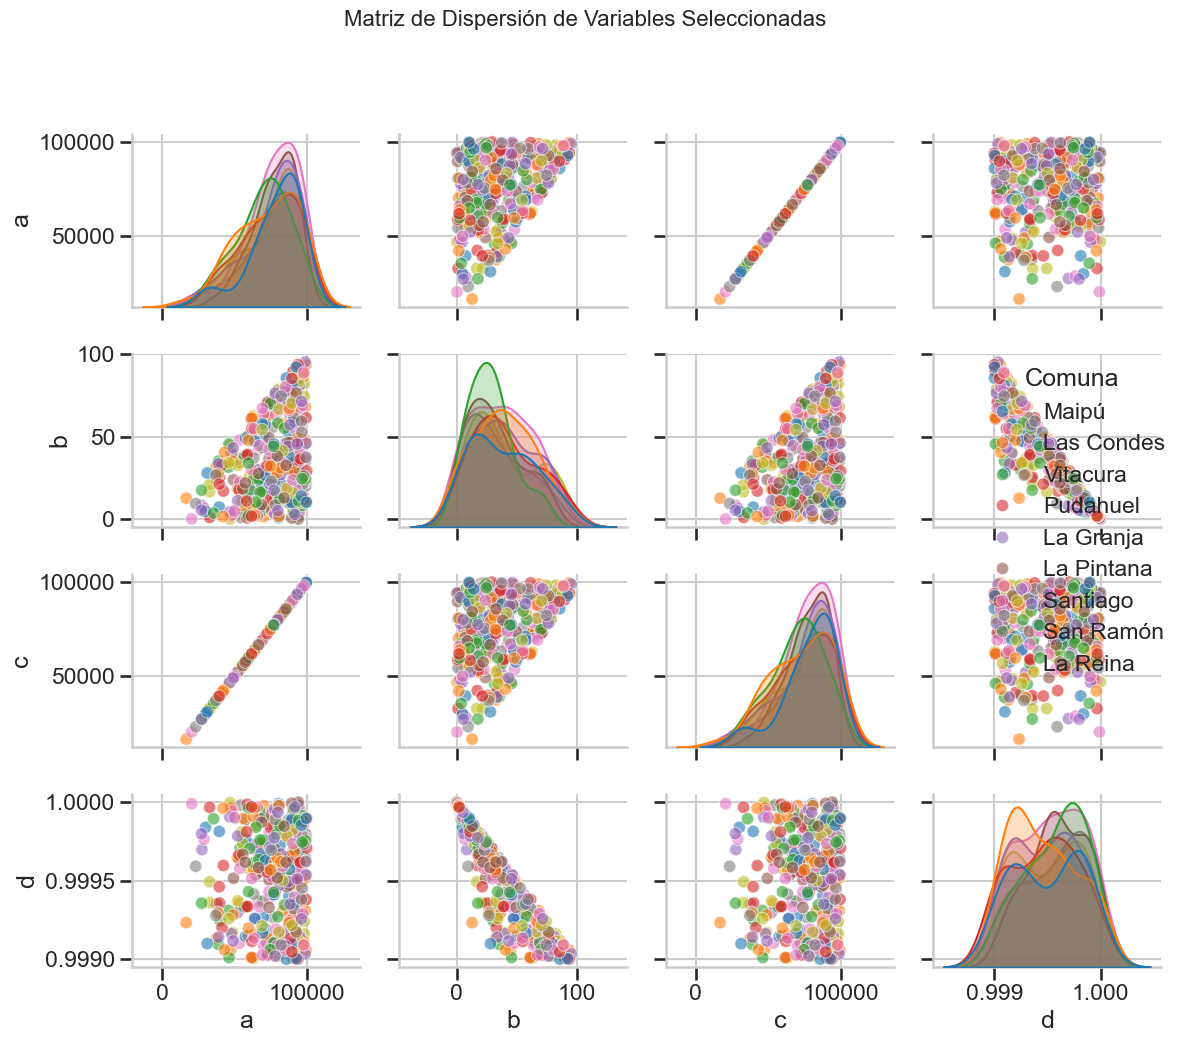

barras multiple

In [ ]:
# Tabla 3: Comorbilidades por tipo de cáncer
data_comorb = {
    'Comorbilidad': ['Hipertensión', 'Diabetes tipo 2', 'Infección urinaria', 'Enfermedad renal crónica',
                     'Hiperplasia prostática benigna', 'Tabaquismo', 'Anemia', 'Hematuria'],
    'Vejiga': [51.8, 22.0, 9.2, 13.4, 4.5, 8.0, 8.8, 7.9],
    'Próstata': [57.7, 24.0, 8.7, 15.1, 1.7, 4.4, 10.2, 4.5],
    'Riñón': [57.4, 26.9, 3.2, 20.8, 4.8, 5.3, 9.9, 1.9],
    'Testicular': [10.4, 3.5, 1.6, 2.2, 0.4, 6.4, 3.5, 0.4]
}

df_comorb = pd.DataFrame(data_comorb)

# Visualización de las comorbilidades por tipo de cáncer
plt.figure(figsize=(14, 8))
df_comorb_melted = pd.melt(df_comorb, id_vars=['Comorbilidad'], 
                         value_vars=['Vejiga', 'Próstata', 'Riñón', 'Testicular'],
                         var_name='Tipo_Cancer', value_name='Porcentaje')
sns.barplot(x='Comorbilidad', y='Porcentaje', hue='Tipo_Cancer', data=df_comorb_melted)
plt.title('Prevalencia de comorbilidades por tipo de cáncer genitourinario')
plt.xlabel('Comorbilidad')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Cáncer')
plt.tight_layout()
plt.show()

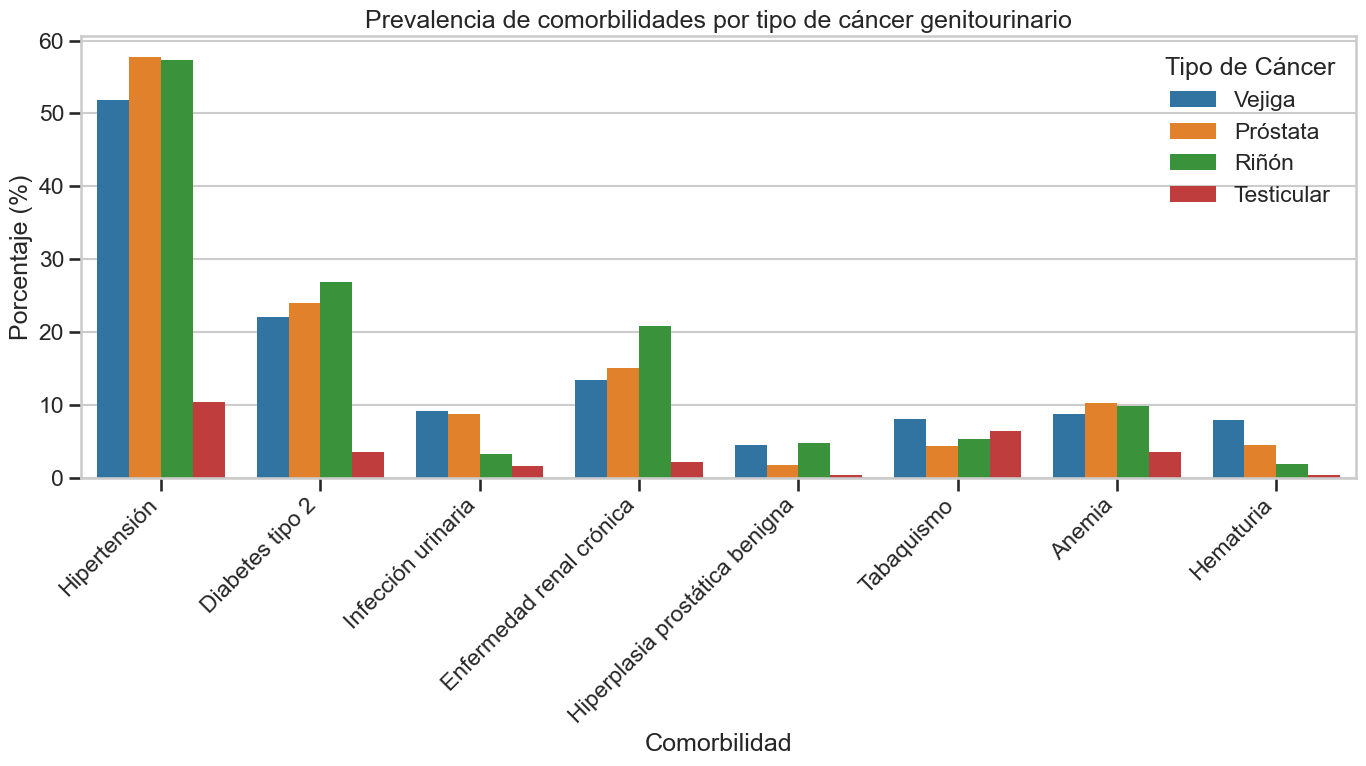

### Medidas tendencia central y dispersion

Central: media, mediana, moda

Dispersion: std, rango, percentiles

Intervalos de confianza:

"they provide a range of values within which we can reasonably expect the true population parameter to lie, given a certain level of confidence."

#### ESTADISTICOS Y AJUSTES

KS Statistic: Mide la distancia máxima entre la distribución empírica de los datos y la distribución teórica ajustada. Valores más bajos indican un mejor ajuste.

p-value: Indica la probabilidad de obtener un KS Statistic al menos tan extremo como el observado, bajo la hipótesis nula de que los datos siguen la distribución teórica. Un p-value alto (típicamente > 0.05) sugiere que no hay evidencia suficiente para rechazar la hipótesis nula, es decir, la distribución teórica es un buen ajuste para los datos.

### Datetime transformer

In [ ]:
# Function to convert string to datetime
import datetime

def convert(date_time):
    format = "%d-%m-%Y"
    datetime_str = datetime.datetime.strptime(date_time, format).date()

    return datetime_str

def day_tf(data_given):
    return data_given.days

Sacando Dias estancia

In [ ]:
#datos_grd['FECHAALTA'] = datos_grd['FECHAALTA'].apply(lambda x: pd.Series(convert(x)))
#datos_grd['FECHA_INGRESO']= datos_grd['FECHA_INGRESO'].apply(lambda x: pd.Series(convert(x)))

#datos_grd['DIAS_ESTANCIA'] = (datos_grd['FECHAALTA'] - datos_grd['FECHA_INGRESO']).apply(lambda x: day_tf(x))

## PARTE 0: Graficos

In [8]:
# Definimos una semilla para reproducibilidad
np.random.seed(42)

# Generamos datos de estancia hospitalaria para diferentes GRDs
# GRD 1: Cirugía cardíaca (estancia más larga y variable)
# GRD 2: Parto normal (estancia media y poco variable)
# GRD 3: Procedimiento ambulatorio (estancia corta y poco variable)

n_pacientes = 200  # Pacientes por GRD

# Simulación de estancias (días)
estancia_grd1 = np.random.gamma(shape=5, scale=2, size=n_pacientes)  # Media ~10 días
estancia_grd2 = np.random.normal(loc=2.5, scale=0.8, size=n_pacientes)  # Media ~2.5 días
estancia_grd3 = np.random.exponential(scale=0.5, size=n_pacientes)  # Media ~0.5 días

# Ajustamos los datos para que sean realistas (sin valores negativos, redondeados)
estancia_grd1 = np.round(estancia_grd1).clip(min=1)
estancia_grd2 = np.round(estancia_grd2).clip(min=1)
estancia_grd3 = np.round(estancia_grd3).clip(min=0)

# Simulación de costos asociados (agregamos cierta variabilidad)
# Base + componente variable basado en la estancia
costo_base_grd1 = 8000  # Base para cirugía cardíaca
costo_dia_grd1 = 1500   # Costo adicional por día
costo_base_grd2 = 2000  # Base para parto
costo_dia_grd2 = 800    # Costo adicional por día
costo_base_grd3 = 1200  # Base para ambulatorio
costo_dia_grd3 = 500    # Costo adicional por día

# Calculamos costos agregando una variabilidad aleatoria
costo_grd1 = costo_base_grd1 + costo_dia_grd1 * estancia_grd1 * (1 + np.random.normal(0, 0.15, n_pacientes))
costo_grd2 = costo_base_grd2 + costo_dia_grd2 * estancia_grd2 * (1 + np.random.normal(0, 0.1, n_pacientes))
costo_grd3 = costo_base_grd3 + costo_dia_grd3 * estancia_grd3 * (1 + np.random.normal(0, 0.08, n_pacientes))

# Creamos un DataFrame con todos los datos
datos_simulados = pd.DataFrame({
    'GRD': np.concatenate([np.ones(n_pacientes), np.ones(n_pacientes)*2, np.ones(n_pacientes)*3]),
    'Descripcion_GRD': np.concatenate([['Cirugía cardíaca']*n_pacientes, ['Parto normal']*n_pacientes, ['Procedimiento ambulatorio']*n_pacientes]),
    'Estancia': np.concatenate([estancia_grd1, estancia_grd2, estancia_grd3]),
    'Costo': np.concatenate([costo_grd1, costo_grd2, costo_grd3])
})

# Mostramos un resumen de los datos simulados
print("Resumen de datos simulados por GRD:")
datos_simulados.groupby('Descripcion_GRD')[['Estancia', 'Costo']].agg(['mean', 'std', 'min', 'max'])


Resumen de datos simulados por GRD:


Estancia                              Costo  \
                              mean       std  min   max          mean   
Descripcion_GRD                                                         
Cirugía cardíaca            10.170  4.533638  1.0  38.0  23476.813727   
Parto normal                 2.470  0.856016  1.0   5.0   3995.265462   
Procedimiento ambulatorio    0.375  0.543925  0.0   3.0   1388.319061   

                                                                  
                                   std         min           max  
Descripcion_GRD                                                   
Cirugía cardíaca           7070.881026  9848.18867  58435.330818  
Parto normal                725.879935  2572.11659   6673.571077  
Procedimiento ambulatorio   273.557615  1200.00000   2675.570357

#### HEATMAP

C:\Users\lenovo\AppData\Local\Temp\ipykernel_10920\1287641813.py:9: FutureWarning: The provided callable <function sum at 0x00000204D9A72FC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tabla_contingencia = pd.pivot_table(df_contingencia, values='Conteo',


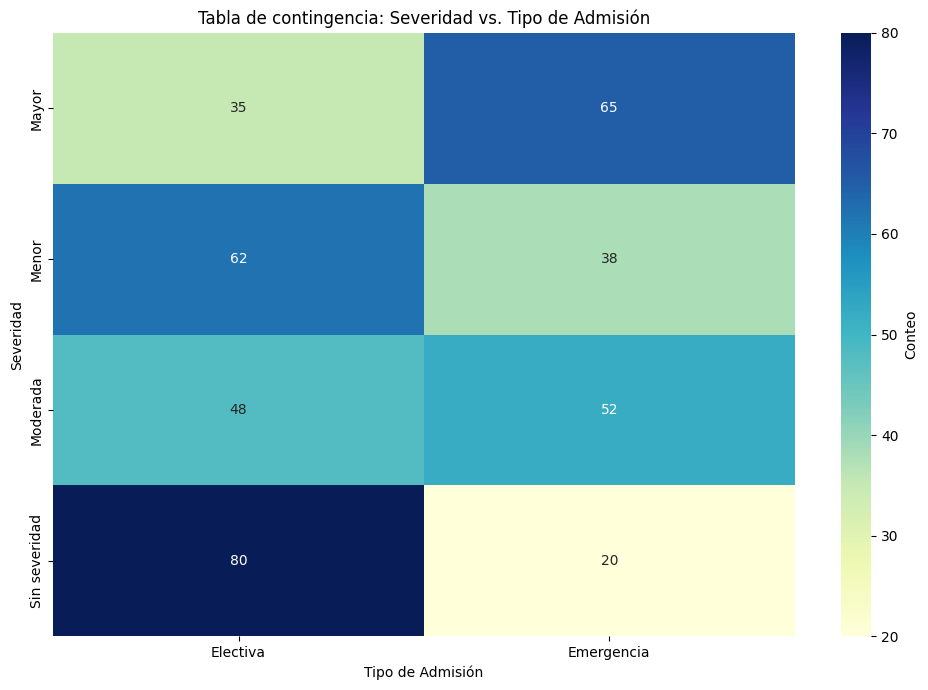

In [11]:
# Ejemplo conceptual de tabla de contingencia
data = {
    'Severidad': ['Mayor', 'Mayor', 'Moderada', 'Moderada', 'Menor', 'Menor', 'Sin severidad', 'Sin severidad'],
    'Tipo_Admisión': ['Emergencia', 'Electiva', 'Emergencia', 'Electiva', 'Emergencia', 'Electiva', 'Emergencia', 'Electiva'],
    'Conteo': [65, 35, 52, 48, 38, 62, 20, 80]
}

df_contingencia = pd.DataFrame(data)
tabla_contingencia = pd.pivot_table(df_contingencia, values='Conteo', 
                               index='Severidad', columns='Tipo_Admisión', aggfunc=np.sum)

# Visualización de la tabla de contingencia
plt.figure(figsize=(10, 7))
sns.heatmap(tabla_contingencia, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={'label': 'Conteo'})
plt.title('Tabla de contingencia: Severidad vs. Tipo de Admisión')
plt.ylabel('Severidad')
plt.xlabel('Tipo de Admisión')
plt.tight_layout()
plt.show()

#### Dispersion Lineal

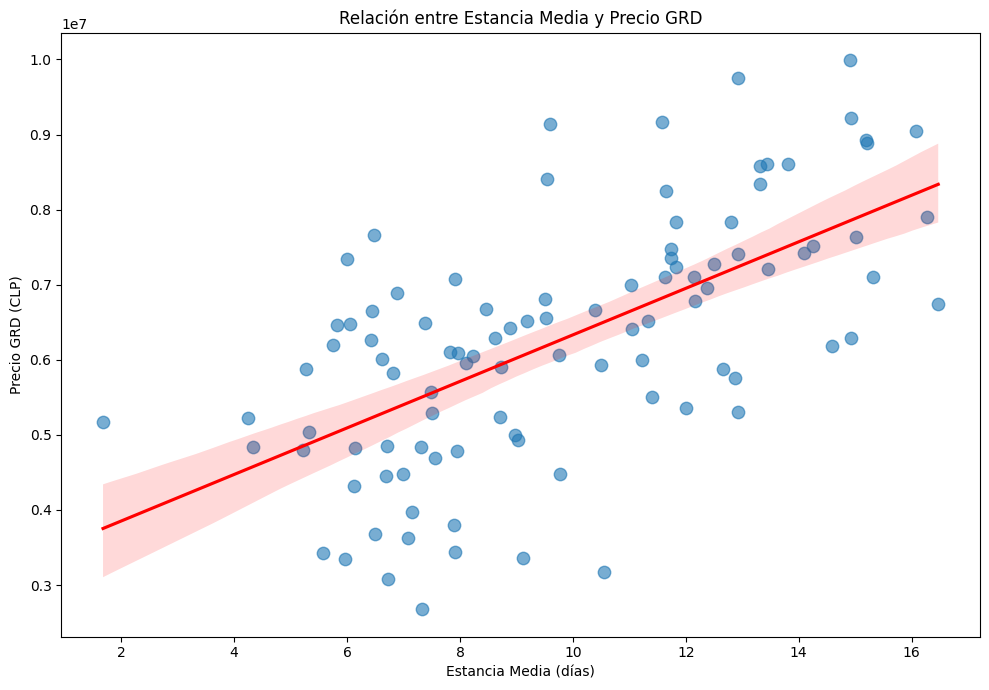

In [12]:
# Diagrama de dispersión con regresión lineal

# Ejemplo conceptual de matriz de correlación
np.random.seed(0)
data_corr = {
    'Edad_Media': np.random.normal(50, 15, 100),
    'Estancia_Media': np.random.normal(7, 3, 100),
    'Precio_GRD': np.random.normal(2500000, 1000000, 100),
    'Peso_GRD': np.random.normal(1.2, 0.5, 100),
}

# Simulamos una correlación positiva entre estancia y precio
data_corr['Precio_GRD'] = data_corr['Precio_GRD'] + data_corr['Estancia_Media'] * 300000
# Simulamos correlación entre peso GRD y precio
data_corr['Precio_GRD'] = data_corr['Precio_GRD'] + data_corr['Peso_GRD'] * 1500000
# Simulamos ligera correlación entre edad y estancia
data_corr['Estancia_Media'] = data_corr['Estancia_Media'] + data_corr['Edad_Media'] * 0.05

df_corr = pd.DataFrame(data_corr)
plt.figure(figsize=(10, 7))
sns.regplot(x='Estancia_Media', y='Precio_GRD', data=df_corr, scatter_kws={"alpha":0.6, "s":80}, 
           line_kws={"color":"red"})
plt.title('Relación entre Estancia Media y Precio GRD')
plt.xlabel('Estancia Media (días)')
plt.ylabel('Precio GRD (CLP)')
plt.tight_layout()
plt.show()

## PARTE 2: Estadistica Multivariada

Tabla contingencia: muestran la distribución de frecuencias de variables categóricas y permiten analizar su asociación.

In [6]:
# Ejemplo conceptual de tabla de contingencia
data = {
    'Severidad': ['Mayor', 'Mayor', 'Moderada', 'Moderada', 'Menor', 'Menor', 'Sin severidad', 'Sin severidad'],
    'Tipo_Admisión': ['Emergencia', 'Electiva', 'Emergencia', 'Electiva', 'Emergencia', 'Electiva', 'Emergencia', 'Electiva'],
    'Conteo': [65, 35, 52, 48, 38, 62, 20, 80]
}

df_contingencia = pd.DataFrame(data)
tabla_contingencia = pd.pivot_table(df_contingencia, values='Conteo', 
                               index='Severidad', columns='Tipo_Admisión', aggfunc=np.sum)

print("Tabla de contingencia:")
print(tabla_contingencia)

Tabla de contingencia:
Tipo_Admisión  Electiva  Emergencia
Severidad                          
Mayor                35          65
Menor                62          38
Moderada             48          52
Sin severidad        80          20


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10920\2619218876.py:9: FutureWarning: The provided callable <function sum at 0x00000204D9A72FC0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tabla_contingencia = pd.pivot_table(df_contingencia, values='Conteo',


Correlacion: miden la fuerza y dirección de la relación lineal entre dos variables numéricas.

corr_matrix = df_contingencia.corr()

Visualizaciones (3 o mas variables)

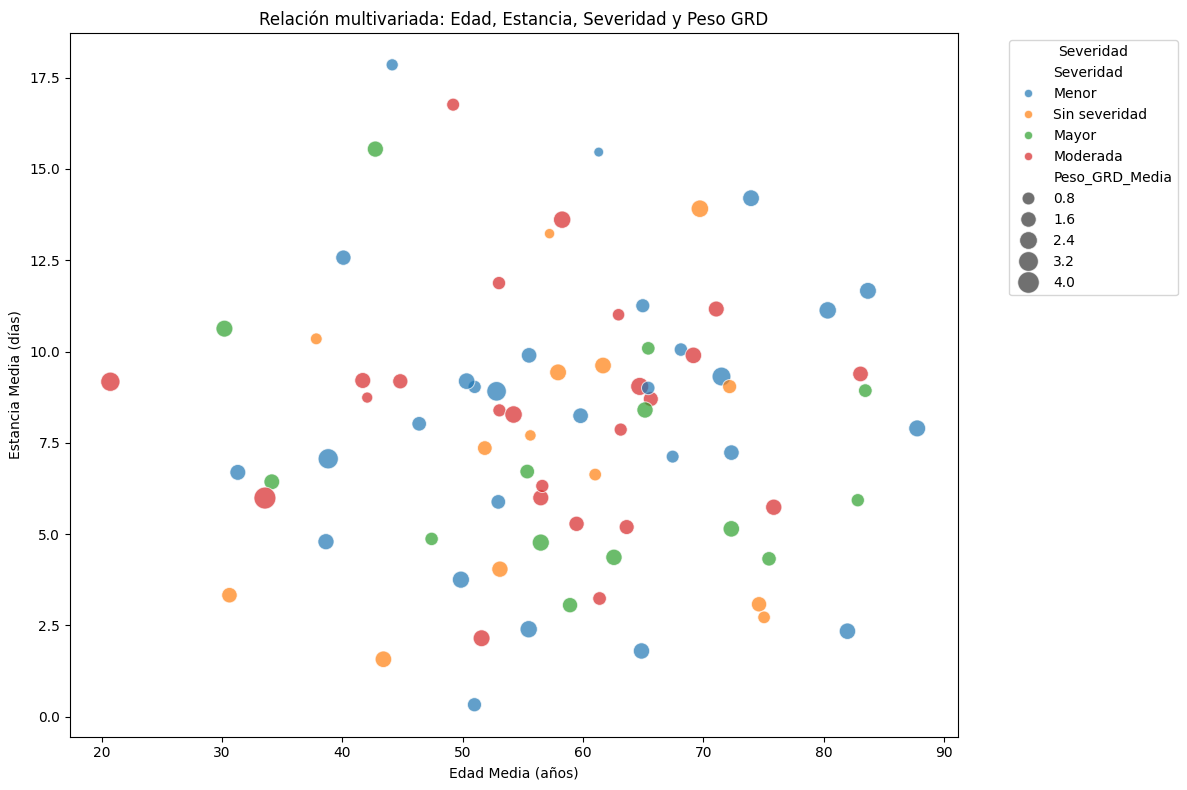

In [13]:
# Ejemplo de gráfico de dispersión con múltiples dimensiones
np.random.seed(42)
n_samples = 80

# Creamos datos simulados para un ejemplo más relacionado con GRD
data_viz = {
    'Edad_Media': np.random.normal(60, 15, n_samples),
    'Estancia_Media': np.random.normal(8, 4, n_samples),
    'Peso_GRD_Media': np.random.normal(1.5, 0.7, n_samples),
    'Severidad': np.random.choice(['Sin severidad', 'Menor', 'Moderada', 'Mayor'], n_samples, 
                                  p=[0.1, 0.4, 0.3, 0.2]),
    'Servicio_Salud': np.random.choice(['Metropolitano Central', 'Metropolitano Norte', 
                                      'Metropolitano Occidente', 'Metropolitano Oriente', 
                                      'Metropolitano Sur'], n_samples),
}

# Añadimos precio GRD basado en estancia y peso
data_viz['Precio_GRD_Media'] = 500000 + (data_viz['Peso_GRD_Media'] * 1000000) + (data_viz['Estancia_Media'] * 200000)
data_viz['Precio_GRD_Media'] = data_viz['Precio_GRD_Media'] * (1 + np.random.normal(0, 0.2, n_samples))

# Convertimos peso GRD a categoría para propósitos de visualización
def categorizar_peso(peso):
    if peso < 1.0:
        return 'Bajo'
    elif peso < 1.5:
        return 'Medio'
    else:
        return 'Alto'

data_viz['Categoria_Peso'] = [categorizar_peso(p) for p in data_viz['Peso_GRD_Media']]

df_viz = pd.DataFrame(data_viz)

# Gráfico de dispersión con múltiples dimensiones
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_viz, x='Edad_Media', y='Estancia_Media', 
                         hue='Severidad', size='Peso_GRD_Media', 
                         sizes=(50, 250), alpha=0.7)

plt.title('Relación multivariada: Edad, Estancia, Severidad y Peso GRD')
plt.xlabel('Edad Media (años)')
plt.ylabel('Estancia Media (días)')
plt.legend(title='Severidad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

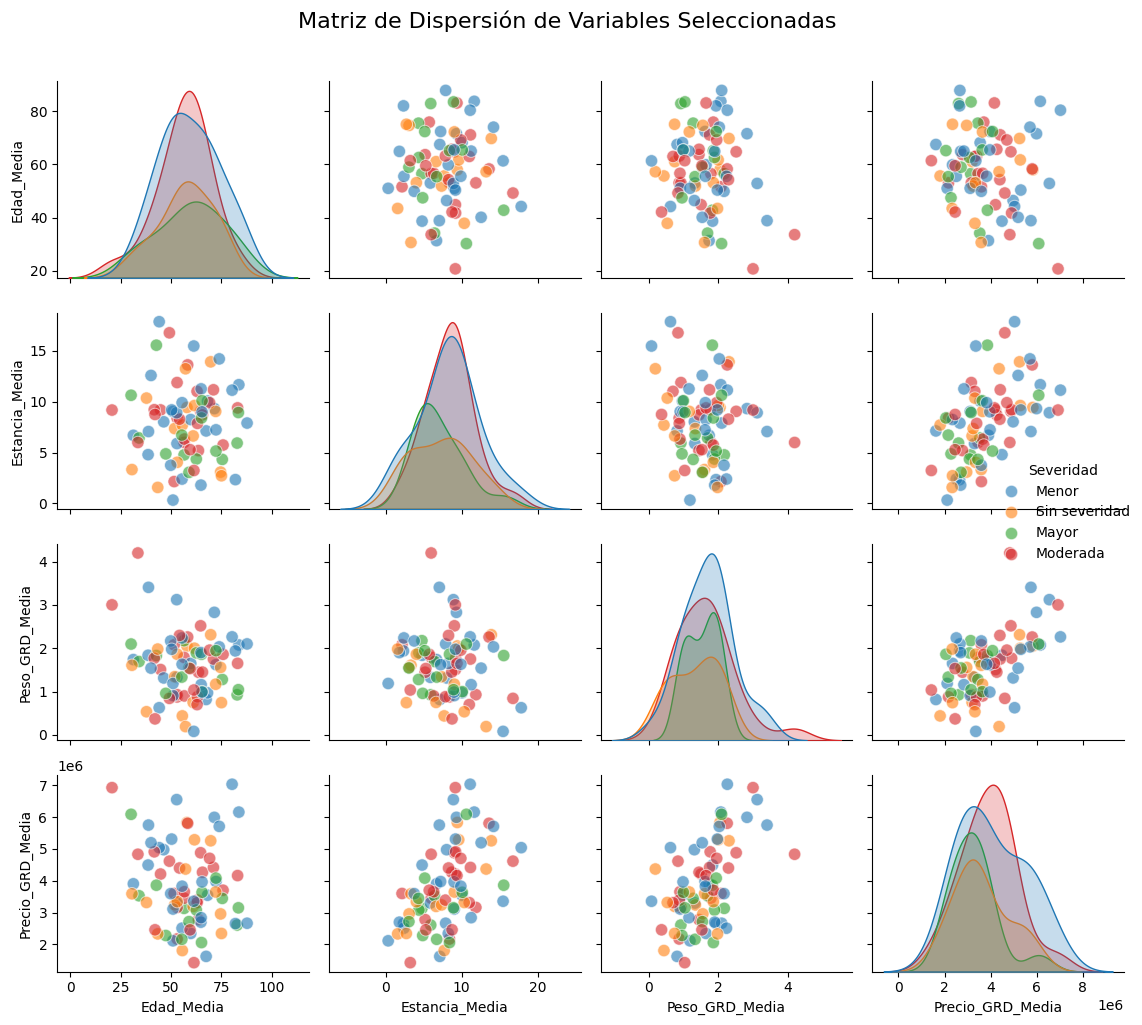

In [14]:
# Pairplot para visualizar relaciones entre múltiples variables numéricas
sns.pairplot(df_viz, vars=['Edad_Media', 'Estancia_Media', 'Peso_GRD_Media', 'Precio_GRD_Media'], 
             hue='Severidad', diag_kind='kde', plot_kws={"alpha": 0.6, "s": 80})
plt.suptitle('Matriz de Dispersión de Variables Seleccionadas', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

#### GROUPBY

Análisis agrupado por Servicio de Salud y Severidad:


,Servicio_Salud,Severidad,Edad_Media,Estancia_Media,Precio_GRD_Media,Peso_GRD_Media
0,Metropolitano Central,Mayor,61.917370,6.827623,3.520015e+06,1.824247
1,Metropolitano Central,Menor,54.402086,8.040764,4.020975e+06,1.822681
2,Metropolitano Central,Moderada,48.343825,7.145115,3.971976e+06,1.792729
3,Metropolitano Central,Sin severidad,43.404975,1.570067,2.331703e+06,1.980382
4,Metropolitano Norte,Mayor,63.059011,4.615368,2.535033e+06,1.143180
5,Metropolitano Norte,Menor,63.783343,7.350682,4.611647e+06,1.912196
6,Metropolitano Norte,Moderada,45.629619,12.750179,3.537191e+06,0.607311
7,Metropolitano Norte,Sin severidad,49.375901,9.204618,3.675808e+06,0.863023
8,Metropolitano Occidente,Mayor,65.154274,8.398605,2.058700e+06,1.860533
9,Metropolitano Occidente,Menor,55.199042,9.168185,4.169430e+06,1.207772


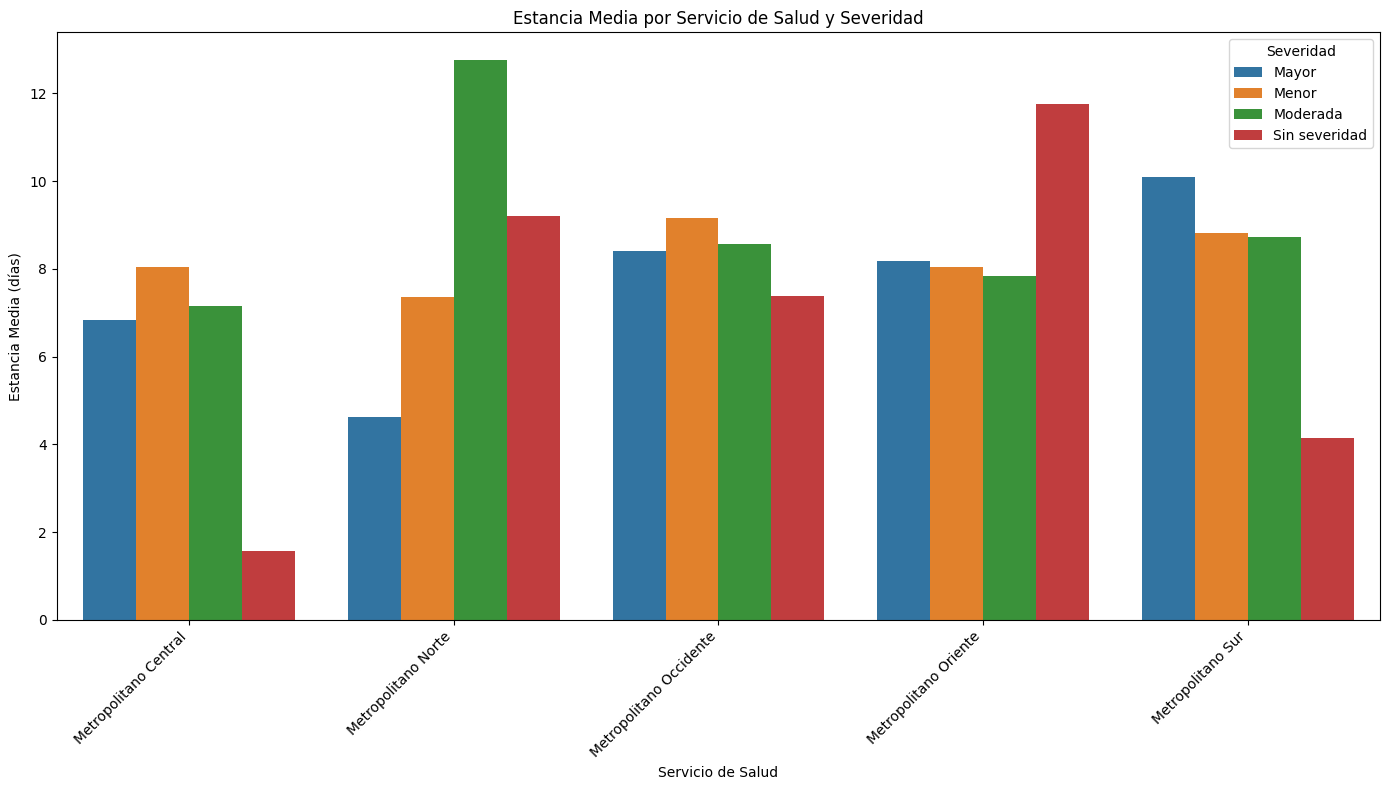

In [15]:
# Ejemplo de análisis de agrupamiento por características clínicas
# Agrupamos por Servicio de Salud y Severidad, y analizamos métricas clave
agrupado = df_viz.groupby(['Servicio_Salud', 'Severidad']).agg({
    'Edad_Media': 'mean',
    'Estancia_Media': 'mean',
    'Precio_GRD_Media': 'mean',
    'Peso_GRD_Media': 'mean'
}).reset_index()

print("Análisis agrupado por Servicio de Salud y Severidad:")
display(agrupado)

# Visualización de métricas por grupo
plt.figure(figsize=(14, 8))
sns.barplot(x='Servicio_Salud', y='Estancia_Media', hue='Severidad', data=agrupado)
plt.title('Estancia Media por Servicio de Salud y Severidad')
plt.xlabel('Servicio de Salud')
plt.ylabel('Estancia Media (días)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Severidad')
plt.tight_layout()
plt.show()

## Parte 5: Simulaciones

Graficos

In [ ]:
# Distribución de niveles de severidad
plt.figure(figsize=(10, 6))
severity_counts = grd_data['SEVERIDAD_CAT'].value_counts().sort_index()
severity_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("YlOrRd", 4))
plt.title('Distribución de Niveles de Severidad')
plt.ylabel('')  # Ocultar etiqueta del eje Y
plt.show()

# Relación entre edad y días de estancia por severidad
plt.figure(figsize=(12, 8))
sns.boxplot(x='SEVERIDAD_CAT', y='DIAS_ESTANCIA', data=grd_data, palette="YlOrRd")
plt.title('Días de Estancia por Nivel de Severidad')
plt.xlabel('Nivel de Severidad')
plt.ylabel('Días de Estancia')
plt.show()

# Relación entre tipo de ingreso y severidad
plt.figure(figsize=(12, 6))
pd.crosstab(grd_data['TIPO_INGRESO'], grd_data['SEVERIDAD_CAT'], normalize='index').plot(
    kind='bar', stacked=True, colormap='YlOrRd')
plt.title('Distribución de Severidad por Tipo de Ingreso')
plt.xlabel('Tipo de Ingreso')
plt.ylabel('Proporción')
plt.legend(title='Nivel de Severidad')
plt.show()

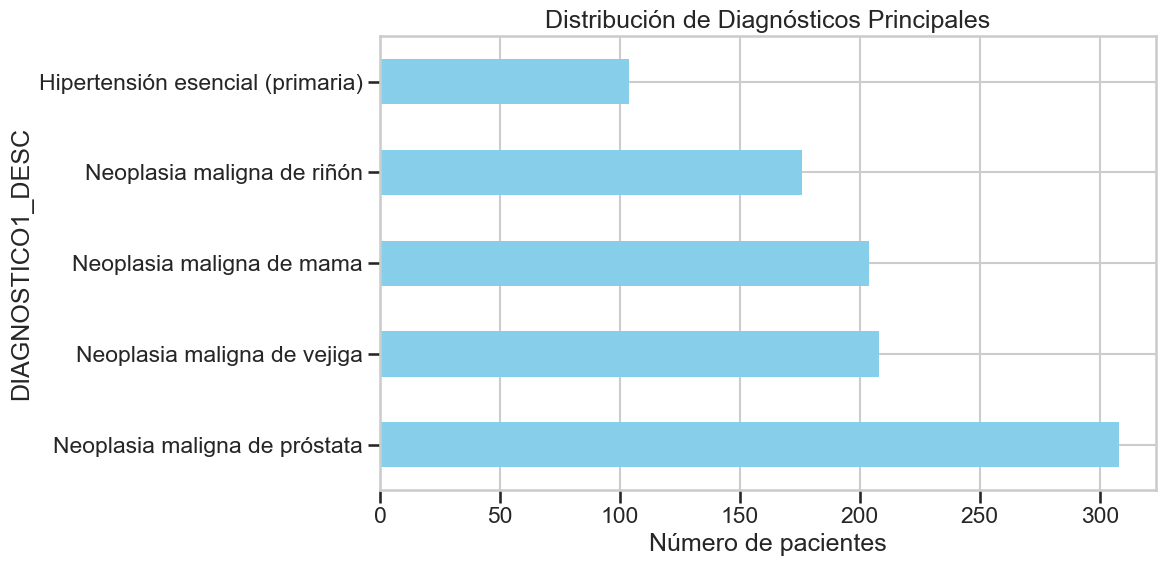

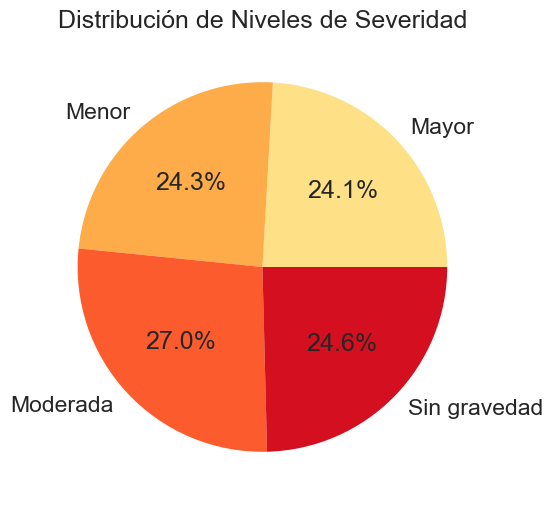

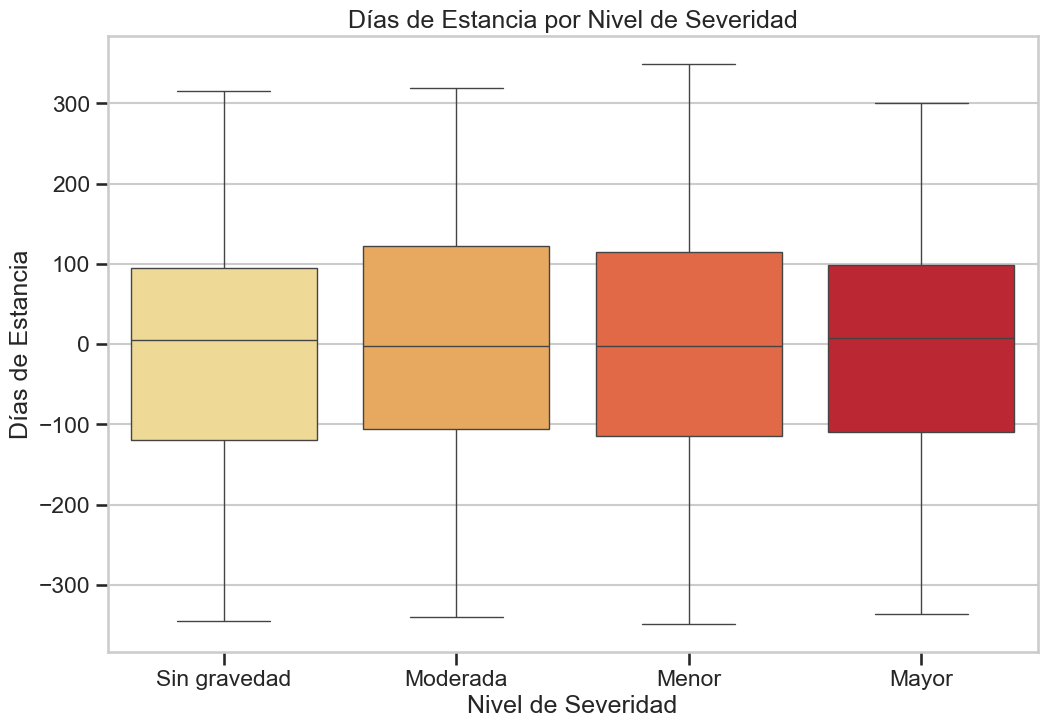

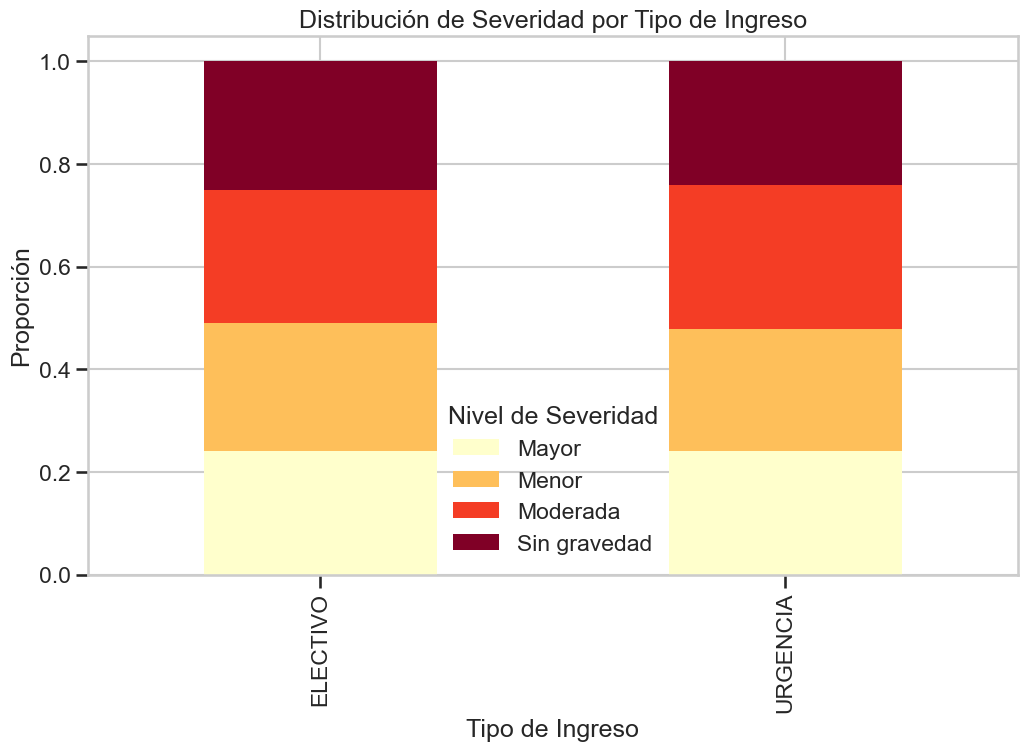

## Parte 6: Estimacion

In [ ]:
# Crear visualización comparativa de IC para natalidad, cesáreas y costos

# Establecer orden de regiones para alinearlas en los tres gráficos
regiones_ordenadas = df_intervalos.sort_values('Media', ascending=True)['Region'].values
orden_regiones = {region: i for i, region in enumerate(regiones_ordenadas)}

def get_region_index(region):
    return orden_regiones[region]

# Configurar figura
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# 1. Tasa de natalidad
ax1 = axes[0]
df_plot = df_intervalos.sort_values('Media', ascending=True).reset_index()
ax1.errorbar(df_plot['Media'], df_plot.index,
             xerr=[df_plot['Media'] - df_plot['IC_Inferior'], df_plot['IC_Superior'] - df_plot['Media']],
             fmt='o', capsize=5, ecolor='black', markersize=8)
ax1.set_yticks(df_plot.index)
ax1.set_yticklabels(df_plot['Region'])
ax1.set_xlabel('Tasa de Natalidad (por 1000 habitantes)')
ax1.set_title('IC 95% - Tasa de Natalidad')
ax1.grid(True, axis='x')

# 2. Proporción de cesáreas
ax2 = axes[1]
df_plot = df_cesarea.copy()
df_plot['Region_Index'] = df_plot['Region'].apply(get_region_index)
df_plot = df_plot.sort_values('Region_Index').reset_index()
ax2.errorbar(df_plot['Proporcion_Cesarea'] * 100, df_plot.index,
             xerr=[
                 (df_plot['Proporcion_Cesarea'] - df_plot['IC_Inferior']) * 100,
                 (df_plot['IC_Superior'] - df_plot['Proporcion_Cesarea']) * 100
             ],
             fmt='o', capsize=5, ecolor='black', markersize=8)
ax2.set_yticks(df_plot.index)
ax2.set_yticklabels(df_plot['Region'])
ax2.set_xlabel('Proporción de Cesáreas (%)')
ax2.set_title('IC 95% - Tasa de Cesáreas')
ax2.grid(True, axis='x')

# 3. Costo GRD
ax3 = axes[2]
df_plot = df_costos.copy()
df_plot['Region_Index'] = df_plot['Region'].apply(get_region_index)
df_plot = df_plot.sort_values('Region_Index').reset_index()
ax3.errorbar(df_plot['Costo_Medio'] / 1e6, df_plot.index,
             xerr=[
                 (df_plot['Costo_Medio'] - df_plot['IC_Inferior']) / 1e6,
                 (df_plot['IC_Superior'] - df_plot['Costo_Medio']) / 1e6
             ],
             fmt='o', capsize=5, ecolor='black', markersize=8)
ax3.set_yticks(df_plot.index)
ax3.set_yticklabels(df_plot['Region'])
ax3.set_xlabel('Costo Medio (millones de pesos)')
ax3.set_title('IC 95% - Costo GRD')
ax3.grid(True, axis='x')

# Título general
plt.suptitle('Comparación de Intervalos de Confianza por Región', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


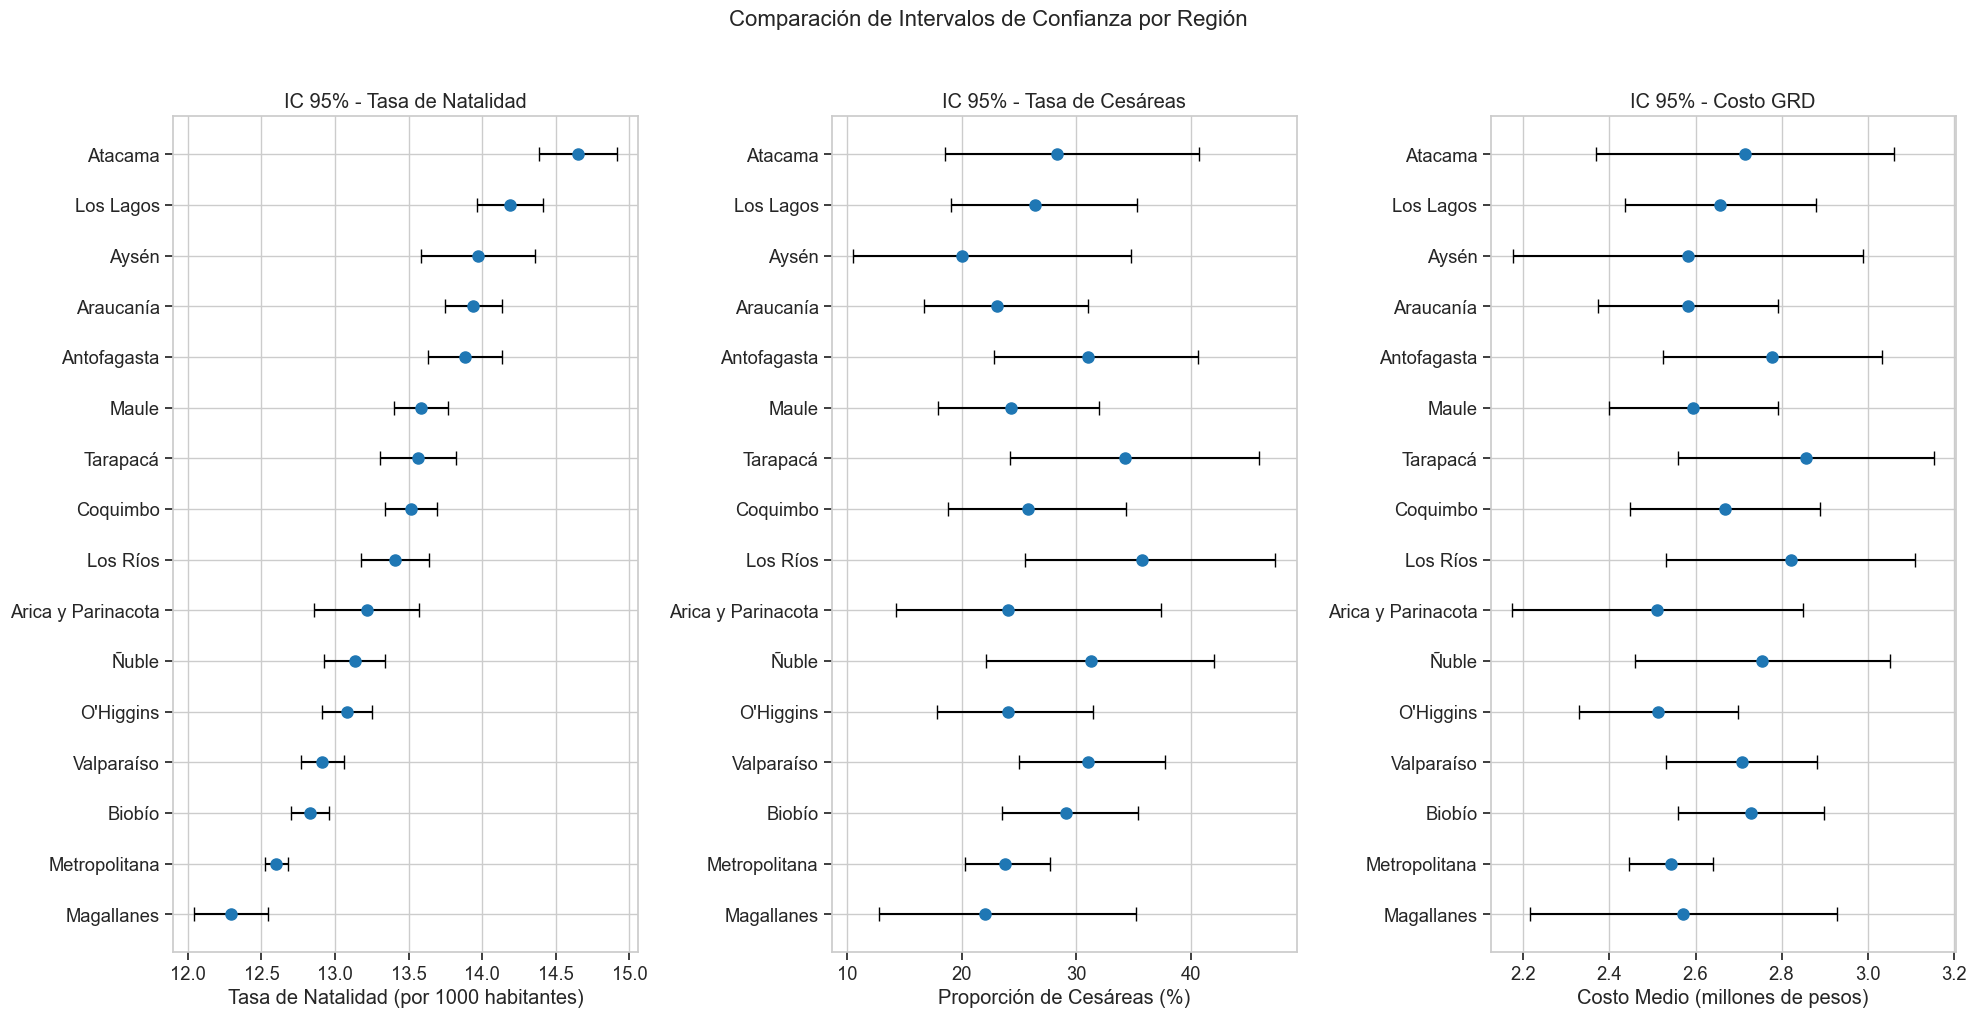

## Parte 8: A/B Testing

### Tipos de Pruebas Relevantes para Datos GRD 🏥📊

- **Pruebas para medias**:  
    - **Prueba t** para una o dos muestras (ej: comparar estancia media, costo medio, etc.)  
    - **ANOVA** para comparar más de dos grupos (hospitales, procedimientos, etc.)  

- **Pruebas para proporciones**:  
    - **Prueba Z** para una o dos proporciones (ej: tasas de mortalidad, reingresos, etc.)  
    - **Chi-cuadrado** para variables categóricas (ej: distribución de tipos de alta, etc.)  

- **Pruebas no paramétricas**:  
    - **Mann-Whitney U** (cuando no se cumple la normalidad)  
    - **Kruskal-Wallis** (alternativa no paramétrica a ANOVA)  

---

### 2. Introducción a A/B Testing con Datos Existentes 🧪🔍

El **A/B testing** tradicional implica la **asignación aleatoria** de sujetos a dos grupos (A y B) para comparar el efecto de diferentes intervenciones. Sin embargo, en el análisis de datos hospitalarios, frecuentemente trabajamos con **datos observacionales ya existentes** (no experimentales).

### A/B Testing Retrospectivo vs. Experimental 🔄🆚🧬

| Característica      | A/B Testing Experimental 🧪 | A/B Testing Retrospectivo 🔙 |
|---------------------|----------------------------|------------------------------|
| **Asignación**      | Aleatoria, controlada 🎲    | No controlada, observacional 👀 |
| **Temporalidad**    | Prospectivo ⏩             | Retrospectivo ⏪             |
| **Causalidad**      | Puede establecer causalidad ✅ | Asociación, causalidad limitada ⚠️ |
| **Control de sesgos** | Mayor control 🛡️         | Requiere técnicas estadísticas adicionales 🧮 |

---

### Técnicas para A/B Testing con Datos Existentes 🛠️

1. **Estratificación**: Analizar subgrupos homogéneos para controlar variables confusoras 🔬
2. **Emparejamiento (Matching)**: Crear pares de casos similares entre los grupos A y B 🤝
3. **Propensity Score Matching**: Emparejar casos basados en la probabilidad de pertenecer al grupo A 📈
4. **Ajuste estadístico**: Controlar variables confusoras mediante regresión u otros métodos 📊

---